<a href="https://colab.research.google.com/github/UW-CTRL/AA548-spr23/blob/main/demos/HJ_reachability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade hj-reachability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import jax
import jax.numpy as jnp
import numpy as np

from IPython.display import HTML
import matplotlib
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import hj_reachability as hj
from hj_reachability import dynamics
from hj_reachability import sets

The noisy Dubins car model where $d$ is some noise on $\omega$ and $\omega$ is a control input. This is a control and disturbance affine dynamics model.

$ \begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\psi} \end{bmatrix} = \begin{bmatrix} v\cos\psi \\ v\sin\psi \\ \omega + d \end{bmatrix} = \begin{bmatrix} v\cos\psi \\ v\sin\psi \\ 0 \end{bmatrix} + \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}\omega + \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}d $

In [2]:
class DubinsCar(dynamics.ControlAndDisturbanceAffineDynamics):

    def __init__(self,
                 evader_speed=3.,
                 evader_max_turn_rate=1.,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None,
                 alpha=0.):
        self.evader_speed = evader_speed
        if control_space is None:
            control_space = sets.Box(lo=jnp.array([-evader_max_turn_rate]), hi=jnp.array([evader_max_turn_rate]))
        if disturbance_space is None:
            disturbance_space = sets.Box(lo=jnp.array([-evader_max_turn_rate * alpha]), hi=jnp.array([evader_max_turn_rate * alpha]))
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        _, _, psi = state
        v_a = self.evader_speed
        return jnp.array([v_a * jnp.cos(psi), v_a * jnp.sin(psi), 0])

    def control_jacobian(self, state, time):
        x, y, _ = state
        return jnp.array([
            [0.],
            [0.],
            [1.],
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [0.],
            [0.],
            [1.],
        ])




In [3]:
### REACH ###
# control_mode = "min"
# disturbance_mode = "max"
####################################

### AVOID or when computing FRS ###
control_mode = "max"
disturbance_mode = "min"
####################################

# model with noisy proportional to the control limits
dynamics_noisy = DubinsCar(alpha=0.6, control_mode=control_mode, disturbance_mode=disturbance_mode)

# no noise on the model
dynamics = DubinsCar(control_mode=control_mode, disturbance_mode=disturbance_mode)

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([-10., -10., 0.]),
                                                                   hi=np.array([10., 10., 2 * np.pi])), (41, 41, 50),
                                                       periodic_dims=2)
# terminal values
values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 3
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

### `hj.step`: propagate the HJ PDE from `(time, values)` to `target_time`.

In [4]:
time = 0.
target_time = -3   # positive time if computing FRS
target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time).block_until_ready()
target_values_noisy = hj.step(solver_settings, dynamics_noisy, grid, time, values, target_time).block_until_ready()


100%|##########|  3.0000/3.0 [00:06<00:00,  2.06s/sim_s]
100%|##########|  3.0000/3.0 [00:05<00:00,  1.90s/sim_s]


In [5]:

fontsize = 24
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 


<Figure size 640x480 with 0 Axes>

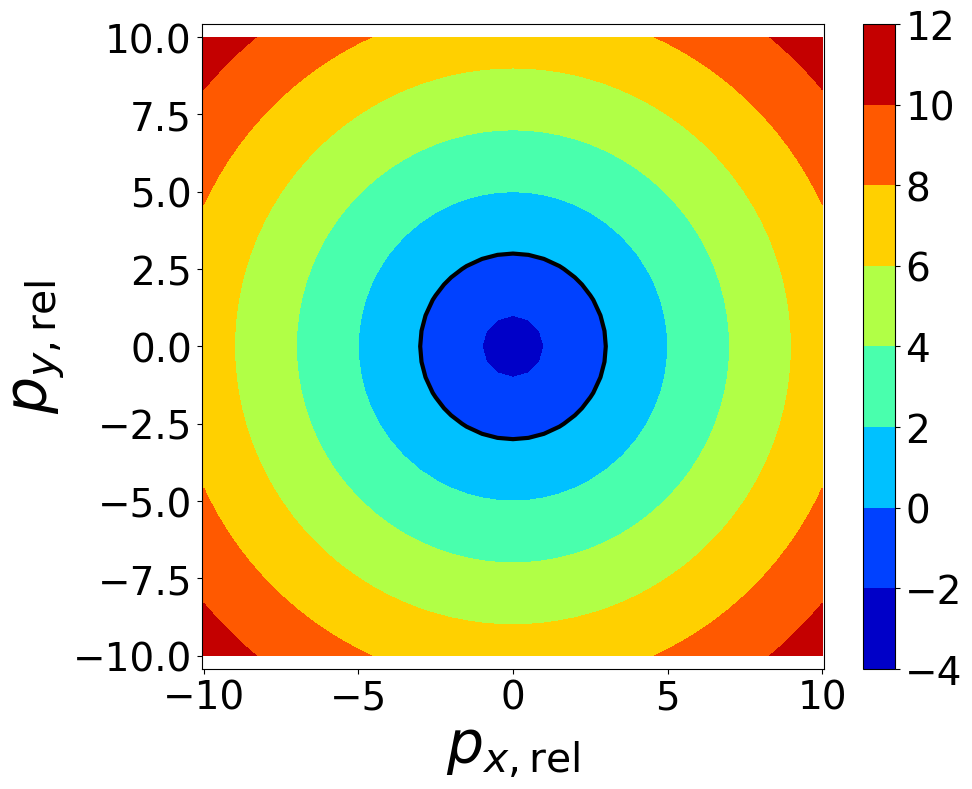

In [6]:
fontsize = 28
plt.jet()
plt.figure(figsize=(10, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], values[:, :, 30].T)
cbar = plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            values[:, :, 30].T,
            levels=0,
            colors="black",
            linewidths=3)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=fontsize)
plt.xlabel("$p_{x, \mathrm{rel}}$", fontsize=1.5*fontsize)
plt.ylabel("$p_{y, \mathrm{rel}}$", fontsize=1.5*fontsize)
plt.axis("equal")
plt.tight_layout()


0.0


<Figure size 640x480 with 0 Axes>

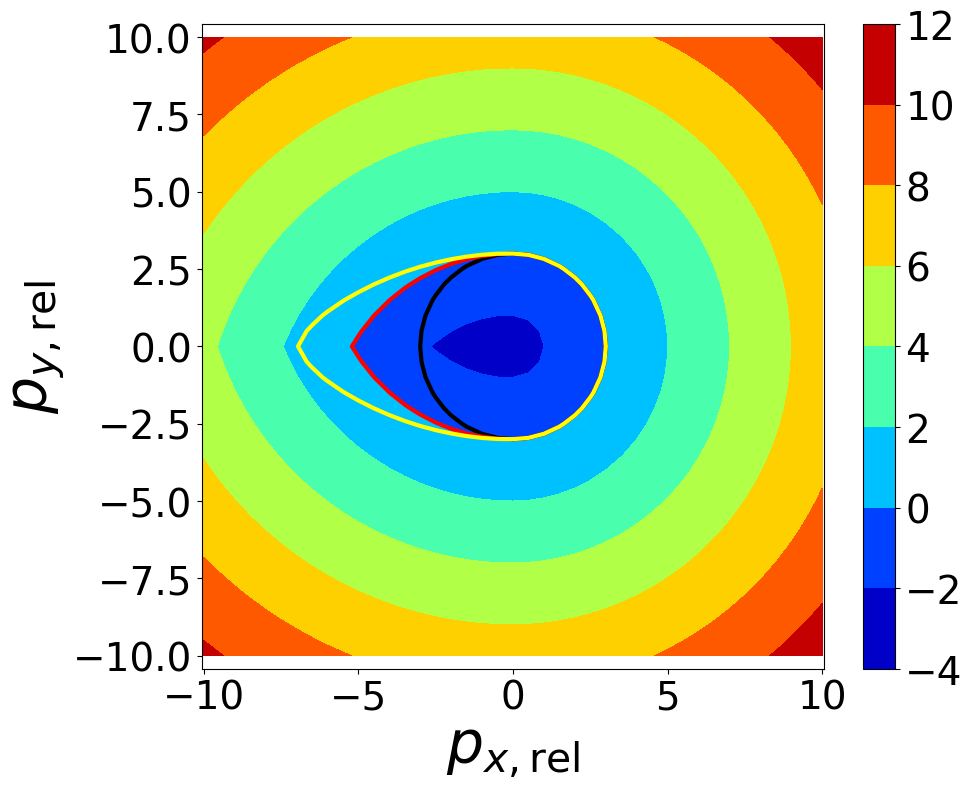

In [7]:
fontsize = 28
theta_i = 0
print(grid.coordinate_vectors[2][theta_i])
plt.jet()
plt.figure(figsize=(10, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :, theta_i].T)
cbar = plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            values[:, :, 30].T,
            levels=0,
            colors="black",
            linewidths=3)
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :, theta_i].T,
            levels=0,
            colors="red",
            linewidths=3)
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values_noisy[:, :, theta_i].T,
            levels=0,
            colors="yellow",
            linewidths=3)



plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=fontsize)
plt.xlabel("$p_{x, \mathrm{rel}}$", fontsize=1.5*fontsize)
plt.ylabel("$p_{y, \mathrm{rel}}$", fontsize=1.5*fontsize)
plt.axis("equal")
plt.tight_layout() 


### `hj.solve`: solve for `all_values` at a range of `times` (basically just iterating `hj.step`).

In [8]:
times = np.linspace(0, -2.8, 57)
initial_values = values
all_values = hj.solve(solver_settings, dynamics, grid, times, initial_values).block_until_ready()
initial_values = all_values[-1]
step_values = hj.step(solver_settings, dynamics, grid, 0.0, initial_values, -0.1).block_until_ready()

100%|##########|  2.8000/2.8 [00:05<00:00,  2.03s/sim_s]
100%|##########|  0.1000/0.1 [00:00<00:00,  1.17sim_s/s]


In [9]:
vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), round(vmax) - round(vmin) + 1)
fig = plt.figure(figsize=(10, 8))

theta_i = 0
def render_frame(i, colorbar=False):
    plt.contourf(grid.coordinate_vectors[0],
                 grid.coordinate_vectors[1],
                 all_values[i, :, :, theta_i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                target_values[:, :, theta_i].T,
                levels=0,
                colors="black",
                linewidths=3)
    plt.axis("equal")


render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation